In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
def income_metric(y,yp,credit,intrestRate = None):
    if (intrestRate == None):
        gain_max = sum(credit)
        gain = sum(np.multiply(credit,(yp==y)))
        return gain/gain_max
    else:
        gain_max = sum(credit*intrestRate)
        gain = sum(np.multiply((yp==y),intrestRate,credit))
        return gain/gain_max

In [3]:
def gain_part(y,yp,credit):
    y = np.matrix(y).transpose()
    gain = [0 for _ in range(len(y))]
    for i in range(len(y)):
        if (yp[i]==0):
            if (y[i]==0):
                gain[i] = 1
            else:
                gain[i] = -1
    gain =  sum(np.multiply(credit,gain))
    return gain

In [4]:
def income_metric2(y,yp,credit,intrestRate = None):
    gain_max = sum(np.multiply(credit,(y==0)))
    y = np.matrix(y).transpose()
    gain = [0 for _ in range(len(y))]
    for i in range(len(y)):
        if (yp[i]==0):
            if (y[i]==0):
                gain[i] = 1
            else:
                gain[i] = -1
    gain =  sum(np.multiply(credit,gain))
    return gain/gain_max

In [5]:
def fuse_model(pipl1,pipl2,X_tr,X_ts,y_tr,y_ts):
#     X_tr.AMT_INCOME_TOTAL <= 300000
    X_model1_tr = X_tr.loc[X_tr.AMT_INCOME_TOTAL <= 200000]
    y_model1_tr = y_tr.loc[X_tr.AMT_INCOME_TOTAL <= 200000]
    X_model1_ts = X_ts.loc[X_ts.AMT_INCOME_TOTAL <= 200000]
    y_model1_ts = y_ts.loc[X_ts.AMT_INCOME_TOTAL <= 200000]

    X_model2_tr = X_tr.loc[X_tr.AMT_INCOME_TOTAL > 200000]
    y_model2_tr = y_tr.loc[X_tr.AMT_INCOME_TOTAL > 200000]
    X_model2_ts = X_ts.loc[X_ts.AMT_INCOME_TOTAL > 200000]
    y_model2_ts = y_ts.loc[X_ts.AMT_INCOME_TOTAL > 200000]
    

    pipl1.fit(X_model1_tr,y_model1_tr)
    y_model1_pred = pipl1.predict(X_model1_ts)

    print("______ MODEL 1 ______")

    conf_matrix = confusion_matrix(y_model1_ts, y_model1_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    balanced_acc = balanced_accuracy_score(y_model1_ts, y_model1_pred)
    print("Balanced Accuracy:", balanced_acc)
    income_per2 = income_metric2(y_model1_ts, y_model1_pred,X_model1_ts.AMT_CREDIT)
    print("Income2 %: ", income_per2)
    print("Income2 base %: ",
            gain_part(y_model1_ts, [0 for _ in range(len(y_model1_ts))],X_model1_ts.AMT_CREDIT)/sum(np.multiply(X_model1_ts.AMT_CREDIT,(y_model1_ts==0))))
    print('Money: ', gain_part(y_model1_ts, y_model1_pred,X_model1_ts.AMT_CREDIT))
    print('Money max: ', sum(np.multiply(X_model1_ts.AMT_CREDIT,(y_model1_ts==0))))


    pipl2.fit(X_model2_tr,y_model2_tr)
    y_model2_pred = pipl2.predict(X_model2_ts)

    print("______ MODEL 2 ______")


    conf_matrix2 = confusion_matrix(y_model2_ts, y_model2_pred)
    print("Confusion Matrix:")
    print(conf_matrix2)
    balanced_acc2 = balanced_accuracy_score(y_model2_ts, y_model2_pred)
    print("Balanced Accuracy:", balanced_acc2)
    income_per22 = income_metric2(y_model2_ts, y_model2_pred,X_model2_ts.AMT_CREDIT)
    print("Income2 %: ", income_per22)
    print("Income2 base %: ",
            gain_part(y_model2_ts, [0 for _ in range(len(y_model2_ts))],X_model2_ts.AMT_CREDIT)/sum(np.multiply(X_model2_ts.AMT_CREDIT,(y_model2_ts==0))))
    print('Money: ', gain_part(y_model2_ts, y_model2_pred,X_model2_ts.AMT_CREDIT))
    print('Money max: ', sum(np.multiply(X_model2_ts.AMT_CREDIT,(y_model2_ts==0))))

    print("______ MODEL FUSED ______")

    gain_max = sum(np.multiply(X_model1_ts.AMT_CREDIT,(y_model1_ts==0))) + sum(np.multiply(X_model2_ts.AMT_CREDIT,(y_model2_ts==0)))
    gain = gain_part(y_model1_ts, y_model1_pred,X_model1_ts.AMT_CREDIT) + gain_part(y_model2_ts, y_model2_pred,X_model2_ts.AMT_CREDIT)

    conf_matrix_fuse = conf_matrix + conf_matrix2
    print("Confusion Matrix fused:")
    print(conf_matrix_fuse)
    # balanced_acc2 = balanced_accuracy_score(y_model2_ts, y_model2_pred)
    # print("Balanced Accuracy:", balanced_acc2)
    print("Income2 fusef %: ", gain/gain_max)



In [7]:
# fuse_model(best_yet,pipeline,X_train,X_test,y_train,y_test)

In [6]:
df = pd.read_csv("./credit_PRO.csv")

# Czyszczenie danych
Zajmujemy sie anomaliami i bledami wykrytymi podczas EDA 

usuwamy odstajace obserwacje z kolumny AMT_INCOME_TOTAL

In [7]:
data = df['AMT_INCOME_TOTAL']
print('Wejściowy rozmiar: ', data.shape[0])
upper_lim = data.quantile(.99)
df = df[( df.AMT_INCOME_TOTAL< upper_lim)]
print('Wyjściowy rozmiar: ', df.shape[0])

Wejściowy rozmiar:  14000
Wyjściowy rozmiar:  13860


-Błędne wartosci w kolumnie DAYS_EMPLOYED mozemy uzupełnić średnią
czy to dobre rozwiazanie? osoby z błędną dana maja problem ze splata w 13% czyli mniej niz w calej populacji
mozemy uzupełnić średnią i dodać dodatkową kolumnę oznaczającą błąd w danych

In [8]:
X = df.drop(["TARGET"],axis = 1)
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature engineering

- poprawienie błędnych i brakujacych wartosci
- transformacje
- skalowanie zmiennych
- wybieranie najbardziej wartosciowych kolumn
- tworzenie nowych zmiennych


## sprawdzamy jakosc kolumn numerycznych w przewidywaniu TARGET

In [9]:
target_column = "TARGET"
num_columns=['AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
df3 = df.loc[(df.DAYS_REGISTRATION!=0)&(df.DAYS_ID_PUBLISH!=0)]
df3 =df3.dropna(axis=0)
m  = -2
im= ""
jm=""
for i in num_columns:
    df3[f'{i}_category'] = pd.cut(df3[i], bins=5, labels=False, duplicates='drop')
    for j in num_columns:
        df3[f" {i} / {j}"] =df3[i]/df3[j]
df3 =df3.dropna(axis=1)
df3 =df3.drop(num_columns,axis=1)

In [10]:

Xt = df3.drop(["TARGET"],axis = 1)
yt = df3["TARGET"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.2, random_state=42, stratify=yt)

sel1 = SelectKBest(score_func=f_classif, k=10)
sel1.fit_transform(X_train_t, y_train_t)


c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 6 17 28 39 50 61 72 83 94] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


array([[ 1.46402000e+05,  2.00000000e+00,  1.11880000e+00, ...,
         1.00000000e+00, -5.70545320e-01,  2.00000000e+00],
       [ 1.42309000e+05,  2.00000000e+00,  1.10560000e+00, ...,
         3.00000000e+00, -3.48312579e-01,  3.00000000e+00],
       [ 1.07008000e+05,  2.00000000e+00,  1.26400000e+00, ...,
         4.00000000e+00, -6.56158244e-01,  3.00000000e+00],
       ...,
       [ 1.44726000e+05,  2.00000000e+00,  1.52800000e+00, ...,
         3.00000000e+00, -1.52417062e+00,  4.00000000e+00],
       [ 1.00108000e+05,  2.00000000e+00,  1.21120000e+00, ...,
         3.00000000e+00, -4.08456781e-01,  3.00000000e+00],
       [ 1.35568000e+05,  2.00000000e+00,  1.00000000e+00, ...,
         3.00000000e+00, -7.71492235e-01,  3.00000000e+00]])

In [11]:
a = df3.columns.tolist()
[a[i] for i, value in enumerate(sel1.get_support()) if value]

['id',
 'FLAG_WORK_PHONE',
 ' AMT_CREDIT / AMT_ANNUITY',
 ' AMT_ANNUITY / DAYS_BIRTH',
 ' AMT_ANNUITY / DAYS_ID_PUBLISH',
 ' AMT_GOODS_PRICE / AMT_INCOME_TOTAL',
 ' AMT_GOODS_PRICE / AMT_CREDIT',
 ' REGION_POPULATION_RELATIVE / DAYS_ID_PUBLISH',
 ' DAYS_BIRTH / AMT_CREDIT',
 ' DAYS_EMPLOYED / DAYS_ID_PUBLISH']

In [12]:
df2 = df[num_columns+["TARGET"]]
df2 = df2.dropna(axis = 0)
Xt = df2.drop(["TARGET"], axis = 1)
yt = df2["TARGET"]
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.2, random_state=42, stratify=yt)

sel2 = SelectKBest(score_func=f_classif,k=5)
sel2.fit_transform(X_train_t, y_train_t)

array([[ 6.7500e+05,  4.9600e-03, -2.3053e+04, -1.0481e+04, -3.4930e+03],
       [ 2.7000e+05,  1.0276e-02, -1.2092e+04, -2.3270e+03, -4.1330e+03],
       [ 1.3500e+06,  1.8801e-02, -1.0204e+04, -4.6810e+03, -2.8650e+03],
       ...,
       [ 1.2060e+06,  2.8663e-02, -2.0629e+04, -9.2580e+03, -3.5720e+03],
       [ 6.8850e+05,  7.3300e-03, -1.0107e+04, -3.9300e+03, -2.7780e+03],
       [ 6.8850e+05,  6.2070e-03, -1.7717e+04, -9.0500e+03, -1.2550e+03]])

In [13]:
a = df2.columns.tolist()
b =[a[i] for i, value in enumerate(sel2.get_support()) if value]
columns_to_subtract = [x for x in num_columns if x not in b]
columns_to_subtract.append('id')
columns_to_subtract

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'id']

# Przegląd zmiennych 

AMT_TOTAL_INCOME - po i przed log
spróbujemy zlogarytmować, a następnie ustandaryzować i zobaczyć czy poprawia to działanie modelu

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

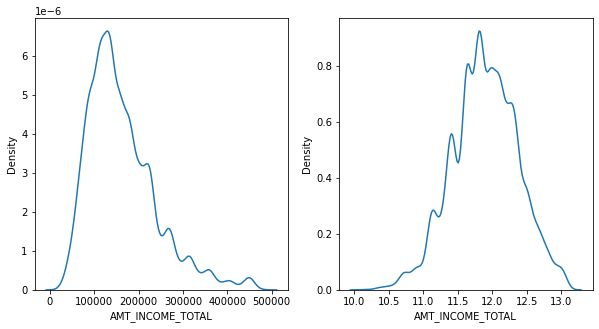

In [81]:
fig,axs = plt.subplots(1,2,figsize = (10,5))
axs = axs.flatten()
sns.kdeplot(data = df.AMT_INCOME_TOTAL,ax = axs[0])
sns.kdeplot(data = np.log1p(df.AMT_INCOME_TOTAL),ax = axs[1])

DAYS_EMPLOYED - 

<Axes: xlabel='DAYS_REGISTRATION', ylabel='Count'>

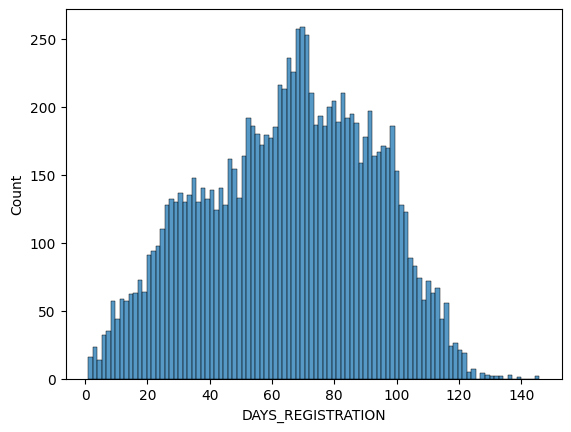

In [93]:
sns.histplot(data=np.sqrt(-X_train.loc[X_train.DAYS_REGISTRATION<0].DAYS_REGISTRATION),bins=100)

<Axes: xlabel='xd', ylabel='Count'>

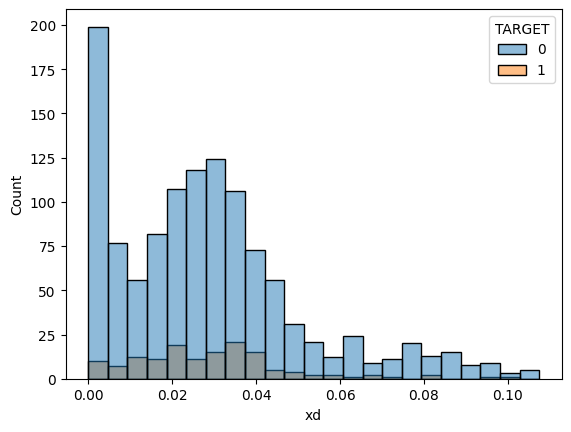

In [87]:
dfxd = df.copy()
dfxd = dfxd.loc[dfxd.REGION_RATING_CLIENT==1]
dfxd['xd'] = ((np.ceil(df.AMT_CREDIT/df.AMT_ANNUITY) * df.AMT_ANNUITY) - df.AMT_CREDIT)/df.AMT_GOODS_PRICE
sns.histplot(data=dfxd,x='xd',hue='TARGET')

<Axes: xlabel='xd', ylabel='Count'>

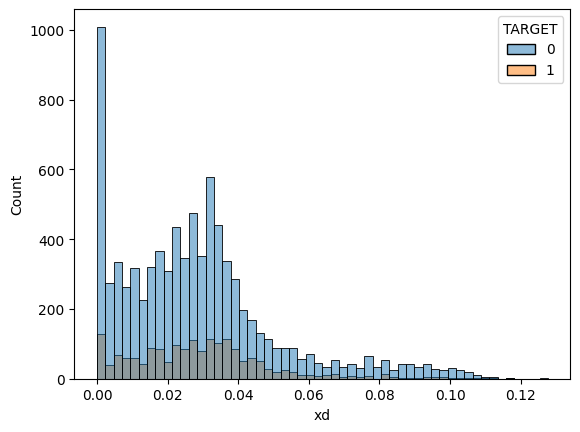

In [88]:
dfxd = df.copy()
dfxd = dfxd.loc[dfxd.REGION_RATING_CLIENT==2]
dfxd['xd'] = ((np.ceil(df.AMT_CREDIT/df.AMT_ANNUITY) * df.AMT_ANNUITY) - df.AMT_CREDIT)/df.AMT_GOODS_PRICE
sns.histplot(data=dfxd,x='xd',hue='TARGET')

<Axes: xlabel='xd', ylabel='Count'>

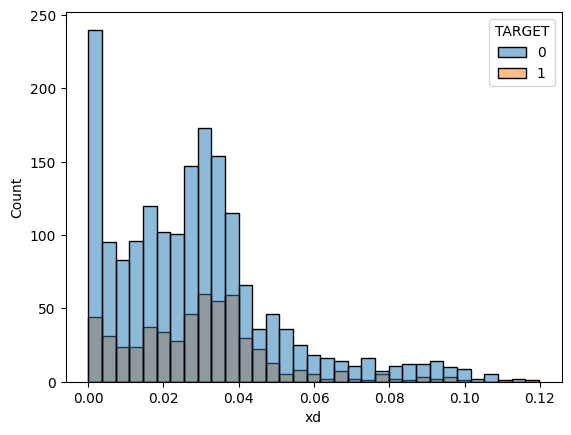

In [86]:
dfxd = df.copy()
dfxd = dfxd.loc[dfxd.REGION_RATING_CLIENT==3]
dfxd['xd'] = ((np.ceil(df.AMT_CREDIT/df.AMT_ANNUITY) * df.AMT_ANNUITY) - df.AMT_CREDIT)/df.AMT_GOODS_PRICE
sns.histplot(data=dfxd,x='xd',hue='TARGET')

In [15]:
goods_price_impute = X_train['AMT_GOODS_PRICE'].dropna().median()
days_employed_impute = df.loc[df["DAYS_EMPLOYED"]<0].DAYS_EMPLOYED.mean()
days_employed_impute

-2350.6807458803123

In [17]:
Xcopy = X_train.copy()
Xcopy['AMT_GOODS_PRICE'] = Xcopy['AMT_GOODS_PRICE'].fillna(goods_price_impute)
Xcopy['rate'] = ((np.ceil(Xcopy.AMT_CREDIT/Xcopy.AMT_ANNUITY) * Xcopy.AMT_ANNUITY) - Xcopy.AMT_CREDIT)/Xcopy.AMT_GOODS_PRICE

<Axes: xlabel='rate', ylabel='Density'>

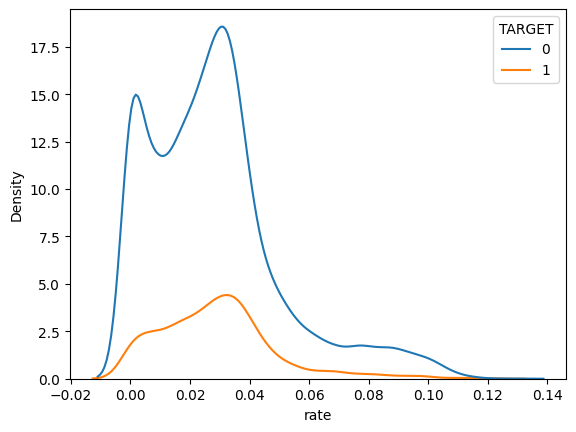

In [21]:
sns.kdeplot(data=  Xcopy,x = 'rate',hue = y_train)

In [16]:
y_test.value_counts()

TARGET
0    2276
1     496
Name: count, dtype: int64

# Analiza podziału ze względu na zysk
 - top 26 % ludzi odpowiedzialnych za 50% dochodów w przyjętym modelu
 - top 19.02 % ludzi odpowiedzialnych za 40 % dochodów 

In [16]:
Xcopy2 = X_train.loc[y_train==0]

In [30]:
max_income =  []
max_gain = X_train.loc[y_train==0].AMT_CREDIT.sum()
for j in np.arange(0.01,0.99,0.01):
    suma = Xcopy2['AMT_CREDIT'].sum() * j
    temp_sum = 0
    ir = 0
    for i in Xcopy2['AMT_CREDIT'].sort_values():
        if (temp_sum < suma and temp_sum + i >=suma):
            if (abs(temp_sum-suma)<abs(temp_sum + i -suma)):
                a = i
                break
            else:
                a = i
                break
        temp_sum += i
        ir = i
        
    y_train_copy = y_train.loc[X_train['AMT_CREDIT']>=a]
    base_loss = X_train['AMT_CREDIT'].loc[(X_train['AMT_CREDIT']>=a) & (y_train_copy==1)].sum()
    base_gain = X_train['AMT_CREDIT'].loc[(X_train['AMT_CREDIT']>=a) & (y_train_copy==0)].sum()

    y_train_copy_2 = y_train.loc[X_train['AMT_CREDIT']<a]
    base_loss_2 = X_train['AMT_CREDIT'].loc[(X_train['AMT_CREDIT']<a) & (y_train_copy_2==1)].sum()
    base_gain_2 = X_train['AMT_CREDIT'].loc[(X_train['AMT_CREDIT']<a) & (y_train_copy_2==0)].sum()
    
    max_gain_group_2 = X_train['AMT_CREDIT'].loc[(X_train['AMT_CREDIT']<a) & (y_train_copy_2==0)].sum()
    max_income.append([j,len(y_train_copy)/(len(X_train)),(base_gain-base_loss)/max_gain,max_gain_group_2/max_gain,(base_gain_2-base_loss_2)/base_gain_2])
#ludzie zapewniający nam top x% dochodu, procent całości jaki stanowi ta grupa, zysk bazowy tej grupy podzielony przez cały możliwy zysk, zmaksymalizowany dochod pozostałych podzielony przez całkowity zysk, bazowy zysk 2 części
    


Jeśli wszystkim ludziom, którzy dostarczają top x% zysku udzielimy kredyt, to przy zmaksymalizowanej reszcze nasz % zysk będzie wynosił

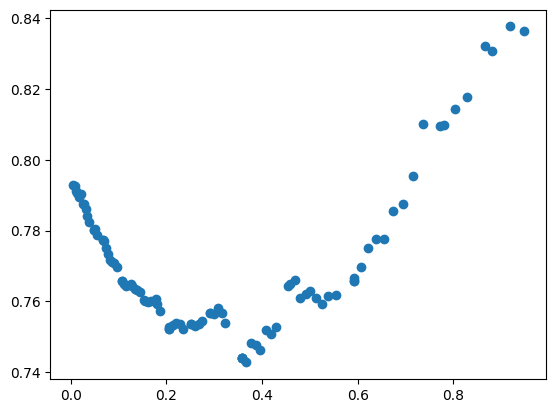

In [33]:
max_income2 =[[],[],[],[],[]]
for i in range(len(max_income)):
    max_income2[0].append((1-max_income[i][0]))
    max_income2[1].append(max_income[i][1])
    max_income2[2].append(max_income[i][2])
    max_income2[3].append(max_income[i][3])
    max_income2[4].append(max_income[i][4])
ych = []
for i in range(len(max_income2[1])):
    ych.append(max_income2[2][i]+max_income2[3][i]*0.8)

plt.scatter(x=max_income2[1],y= max_income2[4])

In [198]:
y_train_copy = y_train.loc[X_train['AMT_CREDIT']>=a]
base_loss = X_train['AMT_CREDIT'].loc[(X_train['AMT_CREDIT']>=a) & (y_train_copy==1)].sum()
base_gain = X_train['AMT_CREDIT'].loc[(X_train['AMT_CREDIT']>=a) & (y_train_copy==0)].sum()
print('Base income%: ', (base_gain-base_loss)/base_gain)


Base income%:  0.9208914075813636


In [178]:
print(Xcopy2['AMT_CREDIT'].loc[Xcopy2['AMT_CREDIT']<a].sum())
print(Xcopy2['AMT_CREDIT'].loc[Xcopy2['AMT_CREDIT']>=a].sum())
print('Procent grupy: ',len(Xcopy2['AMT_CREDIT'].loc[Xcopy2['AMT_CREDIT']>=a])/len(Xcopy2['AMT_CREDIT']))
print('Procent problemow $: ',len(X_train.loc[(X_train['AMT_CREDIT']>=a ) & (y_train==1)])/len(X_train.loc[(X_train['AMT_CREDIT']>=a )]))
print('Procent problemow bez $: ',len(X_train.loc[(X_train['AMT_CREDIT']<a ) & (y_train==1)])/len(X_train.loc[(X_train['AMT_CREDIT']<a )]))

2712123036.0
2736841329.0
Procent grupy:  0.2613711272247858
Procent problemow $:  0.14700609537468626
Procent problemow bez $:  0.18990239787926255


In [157]:
Xcopy3 = X_train.loc[X_train.REGION_RATING_CLIENT==1]

In [161]:
X_train.loc[(X_train.REGION_RATING_CLIENT==1) & (y_train==0)].AMT_CREDIT.sum()

684744741.0

# Do testu:
- ilość rat/wiek
- 

In [14]:
goods_price_impute = X_train['AMT_GOODS_PRICE'].dropna().median()
days_employed_impute = df.loc[df["DAYS_EMPLOYED"]<0].DAYS_EMPLOYED.mean()
days_employed_impute

-2350.6807458803123

In [20]:
class StandardScaler_2(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
        self.classes = classes
        self.std_scaler = [StandardScaler() for _ in range(len(classes))]

    def fit(self,df,y= None):
        for i,col in enumerate(self.classes):
            self.std_scaler[i].fit(np.log1p(df[[col]]))
        return self
    
    def transform(self,X,y= None):
    
        Xc = X.copy()

        Xc.loc[X['CNT_CHILDREN'] > 4, 'CNT_CHILDREN'] = 4

        Xc['AMT_GOODS_PRICE'] = Xc['AMT_GOODS_PRICE'].fillna(goods_price_impute)
        Xc['Rate'] = ((np.ceil(Xc.AMT_CREDIT/Xc.AMT_ANNUITY) * Xc.AMT_ANNUITY) - Xc.AMT_CREDIT)/Xc.AMT_GOODS_PRICE

        Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
        Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute

        # Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        # Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        # Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        # Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT

        for i,col in enumerate(self.classes):
            Xc[col] = self.std_scaler[i].transform(np.log1p(Xc[[col]]))

        Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT


        #Xc['DAYS_EMPLOYED'] = np.log1p(-Xc.DAYS_EMPLOYED)

        return Xc

In [18]:
# class StandardScaler_22(BaseEstimator, TransformerMixin):
#     def __init__(self,classes):
#         self.classes = classes
#         self.std_scaler = [StandardScaler() for _ in range(len(classes))]

#     def fit(self,df,y= None):
#         for i,col in enumerate(self.classes):
#             self.std_scaler[i].fit(np.log1p(df[col]))
#         return self
    
#     def transform(self,X,y= None):
    
#         Xc = X.copy()

#         Xc.loc[X['CNT_CHILDREN'] > 4, 'CNT_CHILDREN'] = 4

#         Xc['AMT_GOODS_PRICE'] = Xc['AMT_GOODS_PRICE'].fillna(goods_price_impute)
#         Xc['Rate'] = ((np.ceil(Xc.AMT_CREDIT/Xc.AMT_ANNUITY) * Xc.AMT_ANNUITY) - Xc.AMT_CREDIT)/Xc.AMT_GOODS_PRICE
#         # Xc['Rate_Count'] = np.ceil(Xc.AMT_CREDIT/Xc.AMT_ANNUITY)

#         Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
#         Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute    
       
#         Xc['DAYS_EMPLOYED'] = -Xc.DAYS_EMPLOYED
#         Xc['DAYS_BIRTH'] = -Xc.DAYS_BIRTH

#         Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
#         Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
#         Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
#         Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT

#         for i,col in enumerate(self.classes):
#             Xc[col] = self.std_scaler[i].transform(np.log1p(Xc[col]))

#         # Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
#         # Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
#         # Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
#         # Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT

#         # # w RandomForestClassifier nie pomogło
#         # s = StandardScaler()
#         # Xc['DAYS_REGISTRATION'] = np.sqrt(-Xc['DAYS_REGISTRATION'])
#         # s.fit(Xc[['DAYS_REGISTRATION']])
#         # Xc['DAYS_REGISTRATION'] = s.transform(Xc[['DAYS_REGISTRATION']])


#         # s1 = StandardScaler()
#         # Xc['DAYS_BIRTH'] = -Xc['DAYS_BIRTH']
#         # s1.fit(Xc[['DAYS_BIRTH']])
#         # Xc['DAYS_BIRTH'] = s1.transform(Xc[['DAYS_BIRTH']])

#         # Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
#         # Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute

#         # Xc['DAYS_EMPLOYED'] = np.log1p(-Xc.DAYS_EMPLOYED)
#         # Xc['DAYS_BIRTH'] = np.log1p(-Xc.DAYS_BIRTH)
#         return Xc


In [19]:
class StandardScaler_22(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
        self.classes = classes
        self.std_scaler = [StandardScaler() for _ in range(len(classes))]

    def fit(self,df,y= None):
        for i,col in enumerate(self.classes):
            self.std_scaler[i].fit(np.log1p(df[[col]]))
        return self
    
    def transform(self,X,y= None):
    
        Xc = X.copy()

        Xc.loc[X['CNT_CHILDREN'] > 4, 'CNT_CHILDREN'] = 4

        Xc['AMT_GOODS_PRICE'] = Xc['AMT_GOODS_PRICE'].fillna(goods_price_impute)
        Xc['Rate'] = ((np.ceil(Xc.AMT_CREDIT/Xc.AMT_ANNUITY) * Xc.AMT_ANNUITY) - Xc.AMT_CREDIT)/Xc.AMT_GOODS_PRICE
        # Xc['Rate_Count'] = np.ceil(Xc.AMT_CREDIT/Xc.AMT_ANNUITY)

        Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
        Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute    
       
        Xc['DAYS_EMPLOYED'] = -Xc.DAYS_EMPLOYED
        Xc['DAYS_BIRTH'] = -Xc.DAYS_BIRTH

        Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT

        for i,col in enumerate(self.classes):
            Xc[col] = self.std_scaler[i].transform(np.log1p(Xc[[col]]))

        # Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        # Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        # Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        # Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT

        # # w RandomForestClassifier nie pomogło
        # s = StandardScaler()
        # Xc['DAYS_REGISTRATION'] = np.sqrt(-Xc['DAYS_REGISTRATION'])
        # s.fit(Xc[['DAYS_REGISTRATION']])
        # Xc['DAYS_REGISTRATION'] = s.transform(Xc[['DAYS_REGISTRATION']])


        # s1 = StandardScaler()
        # Xc['DAYS_BIRTH'] = -Xc['DAYS_BIRTH']
        # s1.fit(Xc[['DAYS_BIRTH']])
        # Xc['DAYS_BIRTH'] = s1.transform(Xc[['DAYS_BIRTH']])

        # Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
        # Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute

        # Xc['DAYS_EMPLOYED'] = np.log1p(-Xc.DAYS_EMPLOYED)
        # Xc['DAYS_BIRTH'] = np.log1p(-Xc.DAYS_BIRTH)
        return Xc


In [18]:
class Dropper(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
        self.classes = classes

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        return Xc.drop(self.classes, axis=1)

In [17]:
class FeatureAdd(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
            return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        Xc['Rate'] = ((np.ceil(X.AMT_CREDIT/X.AMT_ANNUITY) * X.AMT_ANNUITY) - X.AMT_CREDIT)
        return Xc

In [16]:
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
         self.scaler = [MinMaxScaler() for _ in range(len(X))]
         self.classes = classes
         
    def fit(self, X, y=None):
            for i,col in enumerate(self.classes):
                self.scaler[i].fit(X[[col]])
            return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        for i,col in enumerate(self.classes):
             Xc[col] = self.scaler[i].transform(Xc[[col]])
        return Xc

In [15]:
class Transformer(BaseEstimator, TransformerMixin):
    def fit(self, Xc, y=None):
        return self
    
    def transform(self, X):
        Xc = X.copy()
        # modify cnt children
        Xc.loc[X['CNT_CHILDREN'] > 4, 'CNT_CHILDREN'] = 4
        
        # impute missing values
        Xc['AMT_GOODS_PRICE'] = Xc['AMT_GOODS_PRICE'].fillna(goods_price_impute)

        # impute bad values in DAYS_EMPLOYED and add column indicating it
        Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
        Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute

         # stworzenie nowych zmiennych todo
        Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT
        
        # log transforms
        # Xc["AMT_CREDIT"] = np.log1p(Xc["AMT_CREDIT"])
        # Xc["AMT_INCOME_TOTAL"] = np.log1p(Xc["AMT_INCOME_TOTAL"])
        # Xc["AMT_ANNUITY"] = np.log1p(Xc["AMT_ANNUITY"])
        Xc["AMT_GOODS_PRICE"] = np.log1p(Xc["AMT_GOODS_PRICE"])
        
        # skalowanie zmiennych
        s = StandardScaler()
        # Xc["AMT_CREDIT"] = s.fit_transform(Xc[["AMT_CREDIT"]])
        # Xc["AMT_INCOME_TOTAL"] = s.fit_transform(Xc[["AMT_INCOME_TOTAL"]])
        # Xc["AMT_ANNUITY"] = s.fit_transform(Xc[["AMT_ANNUITY"]])
        Xc["AMT_GOODS_PRICE"] = s.fit_transform(Xc[["AMT_GOODS_PRICE"]])
        # Xc[' AMT_CREDIT / AMT_ANNUITY'] = s.fit_transform(Xc[[' AMT_CREDIT / AMT_ANNUITY']]) # tutaj przeskalowanie zmiennych znaczaca metryki modelu
        # Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = s.fit_transform(Xc[[ ' AMT_ANNUITY / DAYS_BIRTH']])
        # Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] = s.fit_transform(Xc[[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL']])
        # Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = s.fit_transform(Xc[[' AMT_GOODS_PRICE / AMT_CREDIT']])

        # wybranie najlepszych kolumn todo
        Xc = Xc.drop(["id",'HOUR_APPR_PROCESS_START']+columns_to_subtract, axis=1)
        

        
        return Xc

In [64]:
best_yet = Pipeline([
    ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ('dropper',Dropper(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED','id'])),
    ("estimator", RandomForestClassifier(random_state=17))
])
best_yet.fit(X_train,y_train)
y_pred = best_yet.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per = income_metric(y_test, y_pred,X_test.AMT_CREDIT)
print("Income %: ", income_per)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


Confusion Matrix:
[[2269    7]
 [ 478   18]]
Balanced Accuracy: 0.5166073757015704
Accuracy: 0.825036075036075
Income %:  0.8350307295535758
Income2 %:  0.8017509600786722


C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


In [69]:
# z rate, nic nie logarytmuje i nie standaryzuje
pipeline_best = Pipeline([
    ('transformer', StandardScaler_22([['id']])),
    ('dropper',Dropper(['AMT_INCOME_TOTAL', 'id'])),
    ("estimator", RandomForestClassifier(random_state=17))
])
pipeline_best.fit(X_train,y_train)
y_pred = pipeline_best.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per = income_metric(y_test, y_pred,X_test.AMT_CREDIT)
print("Income %: ", income_per)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

C:\Users\jancw\AppData\Local\Temp\ipykernel_10628\3550392320.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


Confusion Matrix:
[[2261   15]
 [ 479   17]]
Balanced Accuracy: 0.5138418419411531
Accuracy: 0.8217893217893217
Income %:  0.8318235760371607
Income2 %:  0.7978968174023482


C:\Users\jancw\AppData\Local\Temp\ipykernel_10628\3550392320.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


In [40]:
pipeline = Pipeline([
    ('transformer', StandardScaler_2([['AMT_INCOME_TOTAL','AMT_GOODS_PRICE']])),
    ('dropper',Dropper([ 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'id'])),
    ("estimator", DecisionTreeClassifier(random_state=17))
])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per = income_metric(y_test, y_pred,X_test.AMT_CREDIT)
print("Income %: ", income_per)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

Confusion Matrix:
[[1874  402]
 [ 378  118]]
Balanced Accuracy: 0.5306387833777425
Accuracy: 0.7186147186147186
Income %:  0.7384720578297762
Income2 %:  0.6857132039952523


In [23]:
#with rate, 
pipeline = Pipeline([
    ('transformer', StandardScaler_2([['id']])),
    ('dropper',Dropper([ 'id'])),
    ("estimator", RandomForestClassifier(random_state=17))
])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per = income_metric(y_test, y_pred,X_test.AMT_CREDIT)
print("Income %: ", income_per)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

C:\Users\jancw\AppData\Local\Temp\ipykernel_10628\2482853843.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


Confusion Matrix:
[[2266   10]
 [ 480   16]]
Balanced Accuracy: 0.5139321957027042
Accuracy: 0.8232323232323232
Income %:  0.83409758158994
Income2 %:  0.8006295652431691


C:\Users\jancw\AppData\Local\Temp\ipykernel_10628\2482853843.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


In [253]:
best_n = [[0,0,0,0,0] for _ in range(40)]
for i in range(1,40):
    pipeline = Pipeline([
        ('transformer', StandardScaler_22([['AMT_INCOME_TOTAL','AMT_GOODS_PRICE']])),
        ('dropper',Dropper(['id'])),
        ("estimator", KNeighborsClassifier(n_neighbors=i))
    ])
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    income_per = income_metric(y_test, y_pred,X_test.AMT_CREDIT)
    income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
    best_n[i] = [i,balanced_acc,accuracy,income_per,income_per2]

best_n
# 16 best dla standardScaler 2 i 22

C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\2287126101.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\2287126101.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\2287126101.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with in

[[0, 0, 0, 0, 0],
 [1,
  0.5204288083224673,
  0.7160894660894661,
  0.7233290068979451,
  0.6675152977998057],
 [2,
  0.5120985458359317,
  0.8033910533910534,
  0.8157610501975957,
  0.778593947735846],
 [3,
  0.5309187028743126,
  0.7734487734487735,
  0.7853955880015092,
  0.7421027654032153],
 [4,
  0.5225016299109927,
  0.8152958152958153,
  0.8261767672425434,
  0.7911108601199841],
 [5,
  0.5346515533760418,
  0.8015873015873016,
  0.814797986981079,
  0.7774366027494657],
 [6,
  0.5181717359260729,
  0.8185425685425686,
  0.8295563988476891,
  0.7951722754320286],
 [7,
  0.5279689183060264,
  0.8113275613275613,
  0.8239755903075854,
  0.7884656328429799],
 [8,
  0.5187014569986961,
  0.8207070707070707,
  0.8316925335129417,
  0.7977393392578127],
 [9,
  0.5253061398038438,
  0.816017316017316,
  0.8287267840036034,
  0.7941752997777181],
 [10,
  0.5112056380747207,
  0.8174603174603174,
  0.8292792854125691,
  0.7948392590325916],
 [11,
  0.5170733176483927,
  0.816738816738

In [53]:
pipeline = Pipeline([
    ('transformer', StandardScaler_22(['AMT_INCOME_TOTAL','AMT_GOODS_PRICE'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ('dropper',Dropper(['id'])),
    ("estimator", SVC(kernel="sigmoid", random_state=17, max_iter=3001, probability=True))
])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per = income_metric(y_test, y_pred,X_test.AMT_CREDIT)
print("Income %: ", income_per)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

c:\Users\endoa\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3001).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Confusion Matrix:
[[1908  368]
 [ 397   99]]
Balanced Accuracy: 0.5189548018595158
Accuracy: 0.724025974025974
Income %:  0.7614657071770238
Income2 %:  0.7133454345012356


In [241]:
pipeline = Pipeline([
    ('transformer', StandardScaler_22([['AMT_INCOME_TOTAL','AMT_GOODS_PRICE']])),
    ('dropper',Dropper(['id'])),
    ("estimator", GaussianNB())
])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per = income_metric(y_test, y_pred,X_test.AMT_CREDIT)
print("Income %: ", income_per)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

Confusion Matrix:
[[2276    0]
 [ 496    0]]
Balanced Accuracy: 0.5
Accuracy: 0.8210678210678211
Income %:  0.8321314973928239
Income2 %:  0.7982668567009783


C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\2287126101.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\2287126101.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


In [75]:
pipeline = Pipeline([
    ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
    ('dropper',Dropper(['id'])),
    ("estimator", XGBClassifier(random_state=17,
                    learning_rate=0.1, # Szybkość "uczenia" się
                    booster='gbtree', # Jaki model wykorzystujemy (drzewo - gbtree, liniowe - gblinear)
                    max_depth=70 # Maksymalna głębokość drzewa 
                    ))
])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per = income_metric(y_test, y_pred,X_test.AMT_CREDIT)
print("Income %: ", income_per)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


Confusion Matrix:
[[2228   48]
 [ 461   35]]
Balanced Accuracy: 0.5247374425987869
Accuracy: 0.8163780663780664
Income %:  0.8270890137194501
Income2 %:  0.7922071369461408


C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


# Pierwszy model i baseline

In [50]:
pipeline = Pipeline([
    ('transformer', Transformer()),
    ("estimator", LogisticRegression())
])

In [51]:
pipeline.fit(X_train,y_train)

C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformer', Transformer()),
                ('estimator', LogisticRegression())])

In [52]:
y_pred = pipeline.predict(X_test)

C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


In [60]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per = income_metric(y_test, y_pred,X_test.AMT_CREDIT)
print("Income %: ", income_per)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

Confusion Matrix:
[[2276    0]
 [ 496    0]]
Balanced Accuracy: 0.5
Accuracy: 0.8210678210678211
Income %:  0.8321314973928239
Income2 %:  0.7982668567009783


In [175]:

model = Pipeline([
    ('transformer', Transformer()),
    ("estimator", DecisionTreeClassifier(random_state=17))
])
model.fit(X_train,y_train)
y_pred2 = model.predict(X_test)
conf_matrix2 = confusion_matrix(y_test, y_pred2)
print("Confusion Matrix:")
print(conf_matrix2)
balanced_acc2 = balanced_accuracy_score(y_test, y_pred2)
print("Balanced Accuracy:", balanced_acc2)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy2)
income_per2 = income_metric2(y_test, y_pred2,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


Confusion Matrix:
[[1848  428]
 [ 373  123]]
Balanced Accuracy: 0.5299673309144509
Accuracy: 0.711038961038961
Income2 %:  0.6580654971324685


C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


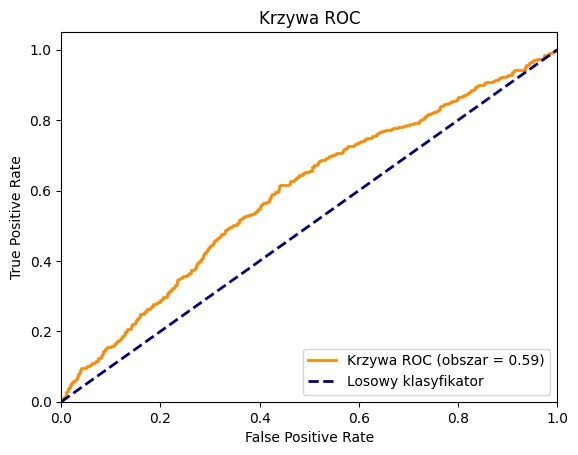

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (obszar = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Losowy klasyfikator')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

- baseline_acc = 0.82
- baseline_balance_acc = 0.5

# Oversampling
- źle działa z KNeighborsClassifier

In [85]:
pipeline1 = ImbPipeline([
    
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('transformer', Transformer(), X_train.columns),
        ],
        remainder='passthrough'
    )),
    ('oversampler', SMOTE()),
    ("estimator", LogisticRegression())
])

In [86]:
pipeline1.fit(X_train,y_train)

C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transformer', Transformer(),
                                                  Index(['id', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START'],
      dtype='object'))])),
                ('oversampler', SMOTE()), ('estimator', LogisticRegression())])

In [87]:
y_pred = pipeline1.predict(X_test)

C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


In [88]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

Confusion Matrix:
[[1321  955]
 [ 218  278]]
Balanced Accuracy: 0.5704440444469641
Accuracy: 0.5768398268398268
Income2 %:  0.5383932599432633


In [43]:
# conf_matrix[0,0]*m-conf_matrix[1,0]*m

C:\Users\jancw\AppData\Local\Temp\ipykernel_12828\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


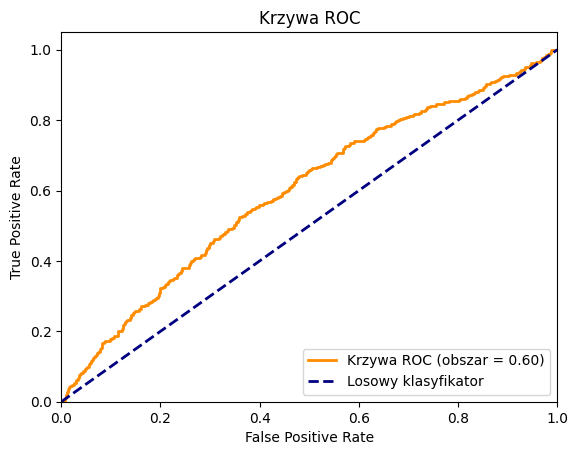

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test,pipeline1.predict_proba(X_test)[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (obszar = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Losowy klasyfikator')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()


In [24]:
pipeline1 = ImbPipeline([
    ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ('dropper',Dropper(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED','id'])),
    ('oversampler', SMOTE(random_state=17)),
    ("estimator", RandomForestClassifier(random_state=17))

])

In [25]:
pipeline1.fit(X_train,y_train)
y_pred = pipeline1.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

C:\Users\jancw\AppData\Local\Temp\ipykernel_24376\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


Confusion Matrix:
[[2023  253]
 [ 402   94]]
Balanced Accuracy: 0.5391780996655139
Accuracy: 0.7637085137085137
Income2 %:  0.7324006203180219


C:\Users\jancw\AppData\Local\Temp\ipykernel_24376\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


# Cross validation

In [66]:
from sklearn.model_selection import KFold

In [71]:
kf = KFold(n_splits=5,shuffle=True,random_state=17)
kf.get_n_splits(df)

5

In [82]:
def cv(n,pipel):
    # zwraca średnią balanced accuracy, średni income, variancje
    ans = []
    kf = KFold(n_splits=n,shuffle=True,random_state=17)
    kf.get_n_splits(df)
    # pipline - musi być ustalony
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        df_cv_train = df.iloc[train_index]
        X_train = df_cv_train.drop(["TARGET"],axis = 1)
        y_train = df_cv_train["TARGET"]

        df_cv_test = df.iloc[test_index]
        X_test = df_cv_test.drop(["TARGET"],axis = 1)
        y_test = df_cv_test["TARGET"]

        
        pipel.fit(X_train,y_train)
        y_pred = pipel.predict(X_test)
        # conf_matrix = confusion_matrix(y_test, y_pred)
        
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
        ans.append([balanced_acc,income_per2])

    return [
        np.matrix(ans)[:,0].mean(),
        np.matrix(ans)[:,1].mean(),
        np.matrix(ans)[:,1].var()]


In [81]:
cv(5,best_yet)

C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with in

[0.5102149578815235, 0.7934975808707698, 0.00013051143729132724]

# Komitety - voting,stacking

In [60]:
p1 = Pipeline([
    ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ('dropper',Dropper(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED','id'])),
    ("estimator", RandomForestClassifier(random_state=17))
]) # mało odżucal
p2 = Pipeline([
    ('transformer', StandardScaler_2([['AMT_INCOME_TOTAL','AMT_GOODS_PRICE']])),
    ('dropper',Dropper([ 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'id'])),
    ("estimator", DecisionTreeClassifier(random_state=17))
]) # dużo odrzucł
p3 = Pipeline([
    ('transformer', StandardScaler_22(['AMT_INCOME_TOTAL','AMT_GOODS_PRICE'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ('dropper',Dropper(['id'])),
    ("estimator", SVC(kernel="sigmoid", random_state=17, max_iter=3001, probability=True))
]) # troche odrzucał
p4 = Pipeline([
        ('transformer', StandardScaler_22(['AMT_INCOME_TOTAL','AMT_GOODS_PRICE'])),
        ('dropper',Dropper(['id'])),
        ("estimator", KNeighborsClassifier(n_neighbors=16))
    ]) # nie wiem
p5 = Pipeline([
            ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
            ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
            ('dropper',Dropper(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'id'])),
            ("estimator", GradientBoostingClassifier(learning_rate=0.3,n_estimators=30,random_state=17))
        ]) # nie wiem

estimators = [("p1",p1), ("p2",p2),("p3",p3),("p4",p4)]
pf = Pipeline([['clf3',
                 VotingClassifier(estimators=estimators,
                                  voting='soft',
                                  weights=[0.3,0.3,0.1,0.2])]])

pf.fit(X_train,y_train)
y_pred = pf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

c:\Users\endoa\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3001).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[2146  130]
 [ 434   62]]
Balanced Accuracy: 0.5339411247803163
Accuracy: 0.7965367965367965
Income2 %:  0.7743467343778426


Stacking

In [61]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

c:\Users\endoa\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3001).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\endoa\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3001).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[2275    1]
 [ 491    5]]
Balanced Accuracy: 0.5048206389251091
Accuracy: 0.8225108225108225
Income2 %:  0.7995169355463442


# Dostrajanie hiperparametrów

In [25]:
dfcotojes = Transformer().transform(X_train)
dfcotojes_test = Transformer().transform(X_test)


C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


In [28]:
opt = BayesSearchCV(
   SVC(),
      {
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
     n_iter=5,
     random_state=17
)


opt.fit(dfcotojes,y_train)
# y_pred = opt.predict(dfcotojes_test)
# conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)
# balanced_acc = balanced_accuracy_score(y_test, y_pred)
# print("Balanced Accuracy:", balanced_acc)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
# income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
# print("Income2 %: ", income_per2)

In [22]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [42]:
cos = ["learning_rate"]
model = GradientBoostingClassifier()

TypeError: GradientBoostingClassifier.__init__() got an unexpected keyword argument 'cos'

In [43]:
from itertools import product

def all_combinations(lists):
    return list(product(*lists))

In [97]:
# Przykładowe listy
learning_rate = [0.05,0.1,0.2,0.3,0.4,0.5]
n_estimators = [20,40,50,70]
max_depth = [4,5,6,7]
min_samples_split = [20,40,60,80,100]
booster = ['gbtree', 'gblinear', 'dart']
criterion = ['gini', 'entropy', 'log_loss']
ccp_alpha = [0,0.05,0.01,0.02]

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [2,3,4,5,6]
max_iter = [800,1000,1700,2500]
# Wszystkie kombinacje
combinations = all_combinations([learning_rate, n_estimators, max_depth])
max_income = 0
max_combination = []
max_conf = None
# Wyświetlenie wyników
for combination in combinations:
    
    p = Pipeline([
    ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
    ('dropper',Dropper(['id'])),
    ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
    ("estimator", GradientBoostingClassifier(learning_rate=combination[0],
                                      n_estimators=combination[1],
                                      max_depth=combination[2]))
    ])
    
    # p.fit(X_train, y_train)
    # y_pred = p.predict(X_test)
    
    income = cv(3,p)[1]
    if (max_income<income):
        max_combination = combination
        max_income = income
        # max_conf = confusion_matrix(y_test,y_pred)
    

C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with in

In [48]:
# [[2261   15]
#  [ 470   26]]
# (0.2, 50, 4)
# 0.8039333324337075
# GradientBoostingClassifier(learning_rate=0.2,
#                                       n_estimators=50,
#                                       max_depth=4)

# (0.1, 'gblinear', 4)
# 0.7958590583476384
# XGBClassifier(random_state=17,
#                     learning_rate=combination[0], # Szybkość "uczenia" się
#                     booster=combination[1], # Jaki model wykorzystujemy (drzewo - gbtree, liniowe - gblinear)
#                     max_depth=combination[2] # Maksymalna głębokość drzewa)

# (4, 'gini', 0, 20)
# 0.7958590583476384
#  RandomForestClassifier(random_state=17,
#                     max_depth=combination[0], # Szybkość "uczenia" się
#                     criterion=combination[1], # Jaki model wykorzystujemy (drzewo - gbtree, liniowe - gblinear)
#                     ccp_alpha=combination[2],
#                     min_samples_split=combination[3] # Maksymalna głębokość drzewa )

# ('poly', 2, 2500)
# 0.7958590583476384
# SVC(random_state=17,
#                     kernel=combination[0],
#                     degree=combination[1],
#                     max_iter=combination[2]
#                     ))

# (0.05, 20, 6)
# 0.7960126491619267
# GradientBoostingClassifier(learning_rate=combination[0],
#                                       n_estimators=combination[1],
#                                       max_depth=combination[2]))
#     ])

[[2261   15]
 [ 470   26]]
(0.2, 50, 4)
0.8039333324337075


In [98]:
print(max_combination)
print(max_income)


(0.05, 20, 6)
0.7960126491619267


In [71]:
p5 = Pipeline([
            ('transformer', StandardScaler_22(['id','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])),
            ('minmax',MinMaxTransformer(['HOUR_APPR_PROCESS_START'])),
            ('dropper',Dropper(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'id'])),
            ("estimator", GradientBoostingClassifier(learning_rate=0.3,
                                      n_estimators=20,
                                      max_depth=4,
                                      min_samples_split=20,
                                      random_state=17))
        ]) # nie wiem

p5.fit(X_train,y_train)
y_pred = p5.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
income_per2 = income_metric2(y_test, y_pred,X_test.AMT_CREDIT)
print("Income2 %: ", income_per2)

C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


[[2257   19]
 [ 483   13]]
Balanced Accuracy: 0.5089308492544928
Accuracy: 0.8189033189033189
Income2 %:  0.7945412148823656


C:\Users\jancw\AppData\Local\Temp\ipykernel_15648\4165558228.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
